# Chest X-Ray Images (Pneumonia) Classification

### Introduction
By Ziv Ben Zvi 203966643 and Julian Rubinstein 204907901.

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.
Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.

As mentioned above, a chest X-ray is a prominent and common way to identify pneumonia. Therefore, developing an accurate model for analyzing the results of a chest X-ray can be extremly helpful in succesfuly diagnosing pneumonia in patients. The following paper will discuss the development of such model and its subsuquent accuracy and efficacy in acomplishing this task. The learning proccess of this model uses the dataset provided in the kaggle competition [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/discussion) and will attempt to classify X-ray lung images to either normal or pneumonia. The dataset contains 5,840 chest X-Ray RGB images (JPEG) divided into NORMAL or PNEUMONIA folders.

<img src="Inkedindex_LI.jpg">

## Imports

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
import cv2

In [2]:
import sklearn
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import class_weight
import shap

## Loading Data and Data Processing

We define the data paths, compress the images by resizing them and then load the data to a list of 2d np arrays which represnt the images:

In [3]:
#NORMAL_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/NORMAL'
#PNEUMONIA_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/PNEUMONIA'
NORMAL_PATH = 'chest_xray/DATA/NORMAL'
PNEUMONIA_PATH = 'chest_xray/DATA/PNEUMONIA'

NORMAL_FILES = glob(NORMAL_PATH + "/*.jpeg")
PNEUMONIA_FILES = glob(PNEUMONIA_PATH + "/*.jpeg")

normal_data = []
pneumonia_data = []

for file in tqdm(NORMAL_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    normal_data.append(image)

for file in tqdm(PNEUMONIA_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    pneumonia_data.append(image)

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/4265 [00:00<?, ?it/s]

Let's print the size of both datasets and the shapes of the images:

In [4]:
print("Number of healthy patients images: " + str(len(normal_data)))
print("Number of sick patients images: " + str(len(pneumonia_data)))
print("Healthy image 1 shape: " + str(normal_data[0].shape))
print("Sick image 1 shape: " + str(pneumonia_data[0].shape))

Number of healthy patients images: 1575
Number of sick patients images: 4265
Healthy image 1 shape: (60, 100, 3)
Sick image 1 shape: (60, 100, 3)


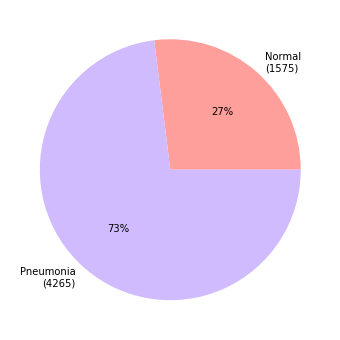

In [5]:
data = [len(normal_data), len(pneumonia_data)]
labels = [f'Normal\n({len(normal_data)})', f'Pneumonia\n({len(pneumonia_data)})']

plt.rcParams["figure.figsize"] = (10,6)
colors = sns.color_palette('pastel')[3:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

plt.show()

Two things can be observed - Firstly, the shape of the images is 60X100X3, as expected following the compression done above and the fact the images are all RGB images. Secondly, we can see that the data contains approximatly 3 times the amount of sick images to healthy images, that is something that should be taken note of as it can affect the training of the model.

Next, in observing the images, it can be noticed that although the images are in RGB format, all the colors appear to be entirely greyscaled. In the following blocks of code we will check the possibility of converting the images to greyscale to both reduce the file-size of the images (which will make the model training faster) and to reduce the complexity of the images which will ease the process of image analysis.

Firstly, lets observe an image before and after converting it to greyscale format:

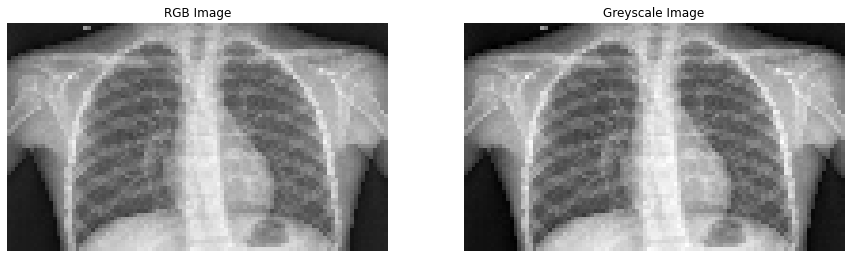

In [13]:
normal_image = normal_data[0]
gray_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2GRAY)
plt.rcParams["figure.figsize"] = (15,7)

fig, ax = plt.subplots(1,2)

ax[0].imshow(normal_image)
ax[0].set_title('RGB Image')
ax[0].axis('off')

ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title('Greyscale Image')
ax[1].axis('off')

plt.show()

In [14]:
print("Before conversion shape: " + str(normal_data[0].shape))
print("After conversion shape: " + str(gray_image.shape))

Before conversion shape: (60, 100, 3)
After conversion shape: (60, 100)


As expected, it can be clearly seen that the conversion to grayscale hardly affects the visual of the image, if at all. Lets attempt to quantitevly show that the process of grayscaling does sacrifice the amount of information contained in the image.

Grayscale-like images are images in which all three RGB colors have similar values. For example - (0,0,0) would be black, (128,128,128) would be grey, and (255,255,255) would be white. On the other hand, (22,166,41) would be dark green. To prove that in approximation all images are grayscale-like, we would like to show that all image cells have approximatly the same value, i.e, low variance.

Lets calculate the standard deviation of every image in the data and calculate the average standard deviations of all images.

In [15]:
NUM_OF_PIXELS = 100*60

standard_deviations = []
sum = 0

for i in tqdm(range(len(normal_data))):
    for row in normal_data[i]:
            for cell in row:
                average = (int(cell[0]) + int(cell[1]) + int(cell[2])) / 3
                deviation = int(cell[0]) + int(cell[1]) + int(cell[2]) - 3 * average
                sum += deviation
            
    standard_deviations.append(sum/NUM_OF_PIXELS)

print("The average standard deviation of all images is: " + str(np.asarray(standard_deviations).mean()))

  0%|          | 0/1575 [00:00<?, ?it/s]

The average standard deviation of all images is: 0.0


As can be seen, all images are purely grayscale, as the standard deviation of all cells is preciesly zero. Therefore, we will proceed to convert all images to grayscale format:

In [16]:
normal_grayscale = []
pneumonia_grayscale = []

for index, image in tqdm(enumerate(normal_data)):
    normal_grayscale.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    
for index, image in tqdm(enumerate(pneumonia_data)):
    pneumonia_grayscale.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### EDA

Firstly, lets define a function to display images:

In [17]:
def plot_images(normal_img, pneumonia_img, plot_color):    
    fig, axis = plt.subplots(2,4)
    plt.rcParams["figure.figsize"] = (15,7)

    for index, image in enumerate(normal_img[:4]):
        axis[0,index].imshow(image, cmap=plot_color)
        axis[0,index].set_title('Normal')
        
    for index, image in enumerate(pneumonia_img[:4]):
        axis[1,index].imshow(image, cmap=plot_color)
        axis[1,index].set_title('Pneumonia')

    plt.show()

As a first step, lets simply observe a number of images of healthy patients and sick patients to see if we can point out any visual difference.

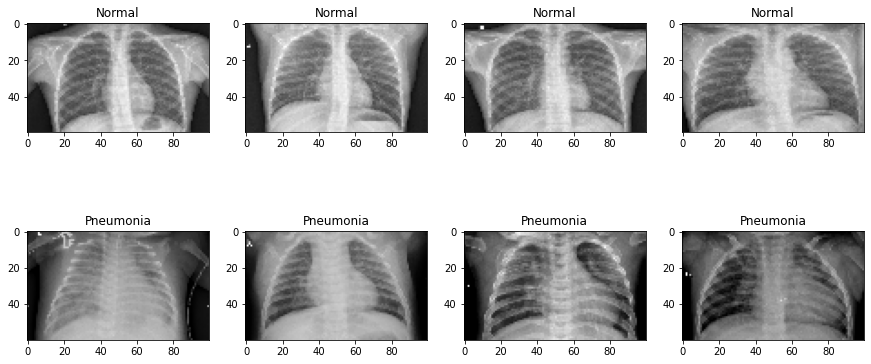

In [18]:
plot_images(normal_data, pneumonia_data, "gray")

By first examination, a slight difference of opacity within the ribcage can be noticed between the normal and the pneumonia-induced images. The pneumonia images appear to have a more cloudy color as opposed to the more transparent normal images (especially in the bottom left image that can be seen above).

Since these images are already converted to grey-scale, we can observe the single color distribution of the images and the mean pixel values:

<AxesSubplot:title={'center':'Pneumonia'}, ylabel='Count'>

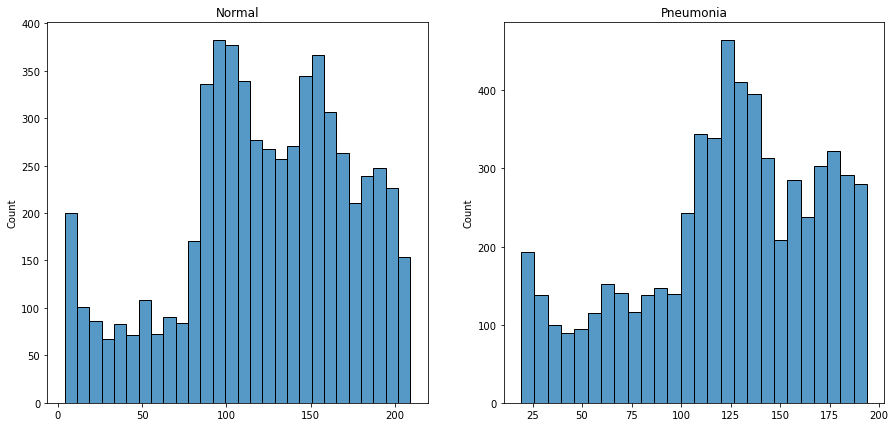

In [19]:
normal_dist = pneumonia_dist = 0
normal_flattened = []
pneumonia_flattened = []

for image in normal_grayscale:
    normal_flattened.append(image.flatten())

for image in normal_flattened:
    normal_dist += image/len(normal_grayscale)

for image in pneumonia_grayscale:
    pneumonia_flattened.append(image.flatten())

for image in pneumonia_flattened:
    pneumonia_dist += image/len(pneumonia_grayscale)

plt.rcParams["figure.figsize"] = (15,7)
plt.subplot(1, 2, 1)
plt.title('Normal')
sns.histplot(normal_dist)

plt.subplot(1, 2, 2)
plt.title('Pneumonia')
sns.histplot(pneumonia_dist)

A slight difference of shape between the distributions can be seen, however, nothing clear enough that can be pointed out without the use of more advanced tools. Lets observe the mean and median pixel values:

The mean pixel value of NORMAL images: 122
The mean pixel value of PNEUMONIA images: 122

The median pixel value of NORMAL images: 132
The median pixel value of PNEUMONIA images: 134

The standard deviation of the pixel value of NORMAL images: 62
The standard deviation of the pixel value of PNEUMONIA images: 59


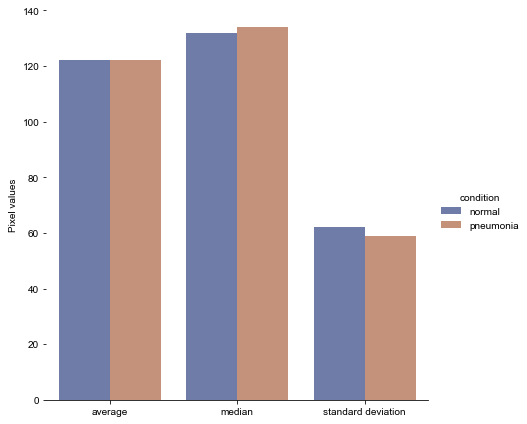

In [20]:
print(f"The mean pixel value of NORMAL images: {int(np.mean(normal_data))}")
print(f"The mean pixel value of PNEUMONIA images: {int(np.mean(pneumonia_data))}")

print(f"\nThe median pixel value of NORMAL images: {int(np.median(normal_data))}")
print(f"The median pixel value of PNEUMONIA images: {int(np.median(pneumonia_data))}")

print(f"\nThe standard deviation of the pixel value of NORMAL images: {int(np.std(normal_data))}")
print(f"The standard deviation of the pixel value of PNEUMONIA images: {int(np.std(pneumonia_data))}")\

normal_mean = int(np.mean(normal_grayscale))
pneumonia_mean = int(np.mean(pneumonia_grayscale))

normal_median = int(np.median(normal_grayscale))
pneumonia_median = int(np.median(pneumonia_grayscale))

normal_std = int(np.std(normal_grayscale))
pneumonia_std = int(np.std(pneumonia_grayscale))

df  = pd.DataFrame({"method" : ["average", "average", "median", "median", "standard deviation", "standard deviation"],
                "value" : [normal_mean, pneumonia_mean, normal_median, pneumonia_median, normal_std, pneumonia_std],
                "condition" : ["normal", "pneumonia", "normal", "pneumonia", "normal", "pneumonia"]},
                index = [1, 2, 3, 4, 5, 6])

plt.rcParams["figure.figsize"] = (15,7)
plot = sns.catplot(
    data=df, kind="bar",
    x="method", y="value", hue="condition",
    ci="None", palette="dark", alpha=.6, height=6
)
plot.despine(left=True)
plot.set_axis_labels("", "Pixel values")

sns.set(font_scale=1.15)


As can be clearly seen, the mean and median pixel values are extremly close and are well in the standard deviation of the pixel distribution. As such, this is not an avenue that will help the analysis.

### Feature extractions

We discovered that some images are in different form than the others. In some cases the images looks zoomed in:

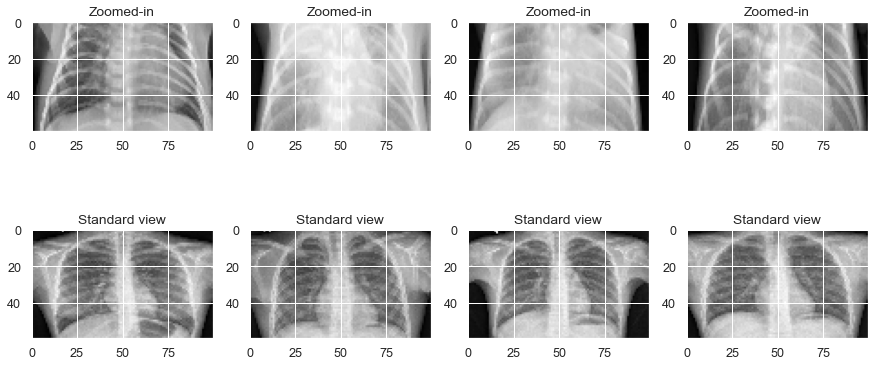

In [21]:
fig, axis = plt.subplots(2,4)
plt.rcParams["figure.figsize"] = (15,7)


axis[0,0].imshow(pneumonia_grayscale[2266], cmap="gray")
axis[0,1].imshow(pneumonia_grayscale[2284], cmap="gray")
axis[0,2].imshow(pneumonia_grayscale[2285], cmap="gray")
axis[0,3].imshow(pneumonia_grayscale[2286], cmap="gray")

axis[0,0].set_title('Zoomed-in')
axis[0,1].set_title('Zoomed-in')
axis[0,2].set_title('Zoomed-in')
axis[0,3].set_title('Zoomed-in')

        
for index, image in enumerate(normal_grayscale[10:14]):
    axis[1,index].imshow(image, cmap="gray")
    axis[1,index].set_title('Standard view')

plt.show()

Moreover, some images contain problematic data like medical devices and actual image data like the sign 'R' in the middle image who states which  is the right side of the figure. 

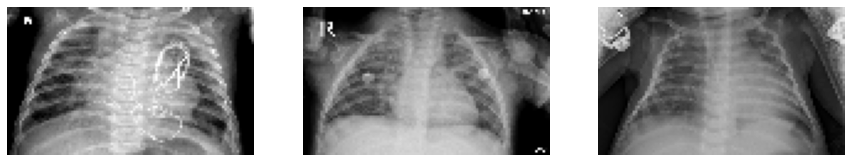

In [22]:
fig, axis = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (13,8)


axis[0].imshow(pneumonia_grayscale[402], cmap="gray")
axis[1].imshow(pneumonia_grayscale[593], cmap="gray")
axis[2].imshow(pneumonia_grayscale[2263], cmap="gray")

axis[0].axis("off")
axis[1].axis("off")
axis[2].axis("off")

plt.show()

Let's look at the images from a egde prespective, with the use of Canny edge detector:

In [23]:
bad_images = []
zoomed_images = []
regular_images = []

bad_img_edges = []
zoomed_img_edges = []
regular_img_edges = []

bad_images.append(pneumonia_grayscale[402])
bad_images.append(pneumonia_grayscale[593])
bad_images.append(pneumonia_grayscale[2263])

zoomed_images.append(pneumonia_grayscale[2266])
zoomed_images.append(pneumonia_grayscale[2284])
zoomed_images.append(pneumonia_grayscale[2285])
zoomed_images.append(pneumonia_grayscale[2286])
 
for image in normal_grayscale[10:14]:
    regular_images.append(image)
    
for i in range(len(bad_images)):
    bad_img_edges.append(cv2.Canny(bad_images[i], 40, 100))

for j in range(len(zoomed_images)):
    zoomed_img_edges.append(cv2.Canny(zoomed_images[j], 40, 100))
    
for z in range(len(regular_images)):
    regular_img_edges.append(cv2.Canny(regular_images[z], 40, 100))

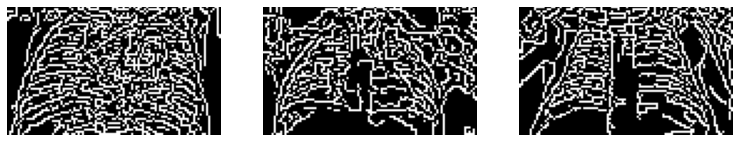

In [24]:
fig, axis = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (13,8)

axis[0].imshow(bad_img_edges[0], cmap="gray")
axis[1].imshow(bad_img_edges[1], cmap="gray")
axis[2].imshow(bad_img_edges[2], cmap="gray")

axis[0].axis("off")
axis[1].axis("off")
axis[2].axis("off")

plt.show()

By looking at the edges of the images with medical devices and data it doesn't look like we can observe any problem. We are hoping that when we will try to classify the images with different models, the models will be able to ignore the "bugs" in the images. Anyway, it seems there are very few images like those showen above and there is no way to locate all of them in our dataset. At the moment we will leave it but will keep that in mind.

Now let's view the zoomed-in images compared to the standard images with respect to their edges:

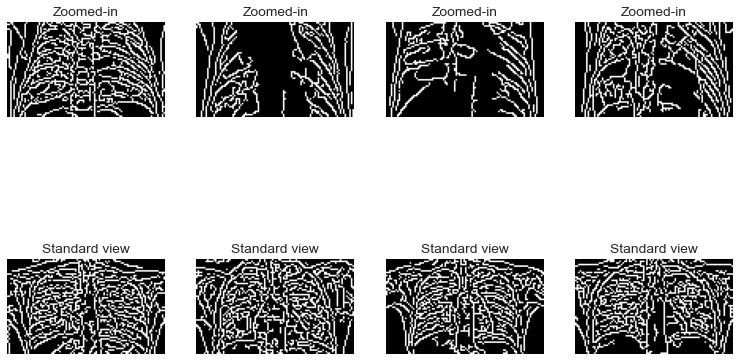

In [25]:
fig, axis = plt.subplots(2,4)
plt.rcParams["figure.figsize"] = (15,7)

axis[0,0].imshow(zoomed_img_edges[0], cmap="gray")
axis[0,1].imshow(zoomed_img_edges[1], cmap="gray")
axis[0,2].imshow(zoomed_img_edges[2], cmap="gray")
axis[0,3].imshow(zoomed_img_edges[3], cmap="gray")

axis[0,0].axis("off")
axis[0,1].axis("off")
axis[0,2].axis("off")
axis[0,3].axis("off")

axis[0,0].set_title('Zoomed-in')
axis[0,1].set_title('Zoomed-in')
axis[0,2].set_title('Zoomed-in')
axis[0,3].set_title('Zoomed-in')

        
for index, image in enumerate(regular_img_edges):
    axis[1,index].imshow(image, cmap="gray")
    axis[1,index].set_title('Standard view')
    axis[1,index].axis("off")

plt.show()

Okay, clearly now we see the differences of the complete figure compared to the zoomed-in figure.
As before, this type of zoomed-in images are very few among our dataset, and it's hard to locate them. further more, it does'nt sound reasonable to zoom in all standard images just to balance the data, especcialy when majority of the images are of regular view.
We will leave it for now, and check for Data Transformations and Augmentation solution later when training classification models.

##### ORB - edge detection method
ORB stands for Oriented FAST and Rotated BRIEF, which are two algorithms used for feature extraction from an image. For our needs we will focus on the FAST method of The ORB algorithm, which means edge detection in an image. Our definition of an edge is as follow:<br>
Given a pixel p of a 2D image, the algorithm compares the value of p to his surrounding 16 pixels that are in a circle around him. The pixel's value stands for brightness. The pixels surrounding p is then sorted into three categories:
- Lighter than p
- Darker than p 
- Similar to p

In case of more than 8 pixels are brighter or darker than p, the pixel p is selected as a keypoint. Keypoints calculated by ORB algorithm gives us information of the location of determining edges in an image.<br>For our use, we would like to compare the amount of keypoints founded by ORB in normal and pneumonia images. Many keypoints will stand for high contrast between neighbour pixels in an image, where few keypoints will present low contrast between neighbour pixels.

Let's set our ORB algorithm

In [26]:
orb = cv2.ORB_create(edgeThreshold=15,
                     patchSize=31,
                     nlevels=8,
                     fastThreshold=20,
                     scaleFactor=1.2,
                     WTA_K=2,
                     scoreType=cv2.ORB_HARRIS_SCORE,
                     firstLevel=0,
                     nfeatures=250)

In [27]:
normal_orb_data = []
pneumonia_orb_data = []

for image in normal_grayscale:
    normal_orb_data.append(image)
    
for image in pneumonia_grayscale:
    pneumonia_orb_data.append(image)

After copying our data to a different array in order to leave the original data unchanged, we will run the algorithm with our copied images and plot the pixels values

In [28]:
normal_orb_keypoints = []
pneumonia_orb_keypoints = []

for image in normal_orb_data:
    keypoint, desc = orb.detectAndCompute(image,None)
    normal_orb_keypoints.append(len(keypoint))
    
for image in pneumonia_orb_data:
    keypoint, desc = orb.detectAndCompute(image,None)
    pneumonia_orb_keypoints.append(len(keypoint))

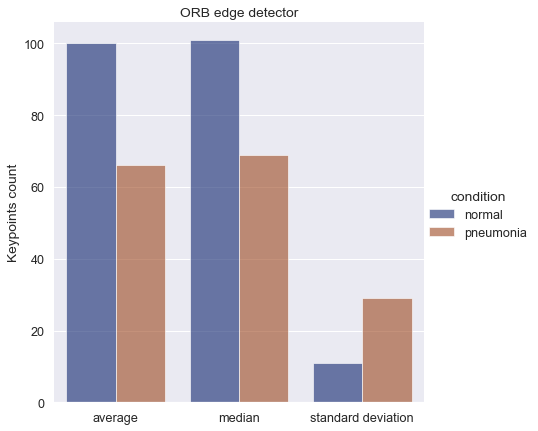

In [29]:
normal_mean = int(np.mean(normal_orb_keypoints))
pneumonia_mean = int(np.mean(pneumonia_orb_keypoints))

normal_median = int(np.median(normal_orb_keypoints))
pneumonia_median = int(np.median(pneumonia_orb_keypoints))

normal_std = int(np.std(normal_orb_keypoints))
pneumonia_std = int(np.std(pneumonia_orb_keypoints))
    
df  = pd.DataFrame({"method" : ["average", "average", "median", "median", "standard deviation", "standard deviation"],
                    "value" : [normal_mean, pneumonia_mean, normal_median, pneumonia_median, normal_std, pneumonia_std],
                    "condition" : ["normal", "pneumonia", "normal", "pneumonia", "normal", "pneumonia"]},
                    index = [1, 2, 3, 4, 5, 6])

plt.rcParams["figure.figsize"] = (15,7)
plot = sns.catplot(
        data=df, kind="bar",
        x="method", y="value", hue="condition", 
        ci="None", palette="dark", alpha=.6, height=6
    )
plot.despine(left=True)
plot.set_axis_labels("", "Keypoints count")
plt.title("ORB edge detector")    
sns.set(font_scale=1.15)

As seen the normal images seems to have a more contrast between neighbour pixels, which means we are more likely to see dark and bright parts in a given normal image, while on pneumonia images we will probably observe monotonous brightness level.

## PCA

We will start by defining our pca model and compiling it on our combined dataset of images of both the pneumonia and normal images: 

In [30]:
combined_pca = sklearn.preprocessing.StandardScaler().fit_transform(normal_flattened + pneumonia_flattened)
pca = sklearn.decomposition.PCA(n_components = 6)
pca.fit(combined_pca)
combined_reduced = pca.transform(combined_pca)
combined_pca_df = pd.DataFrame(data=combined_reduced,columns=['PC1','PC2','PC3','PC4','PC5','PC6'] )
combined_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-11.739896,20.709378,33.057157,-3.488305,10.704758,36.681711
1,-47.465511,-12.719462,17.865605,4.914120,-12.638038,10.980093
2,-22.774161,23.508687,37.292036,9.330602,13.611187,19.670853
3,-35.245922,54.317781,30.141210,14.385822,-13.055834,0.495452
4,-25.918642,27.331506,38.633682,20.172778,14.769083,12.065550


We can see that the first PC contains about a third of the variance in the images while the first three combined hold almost half of all the variance between the images. Therefore we will only analyze the first 3 PCs. We will now proceed to divide the images based on their PC scores and see if any of them will show a pattern of normal/pneumonia images or have any visible properties which can help to analyze the images. All PCs will be shown with the first 2 rows of images corresponding to the higest score and the second 2 rows will correspond to the low pc score.

explained variance ratio (first three components): [0.29068861 0.09298998 0.06840393]
sum of first three components: 0.452083


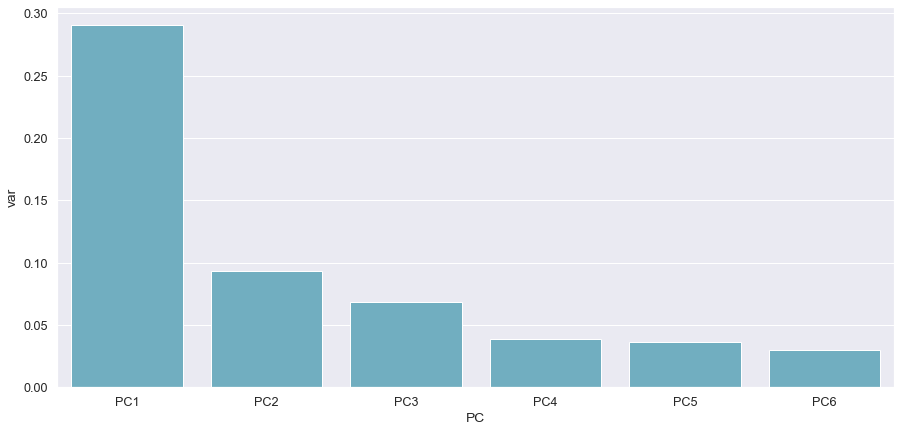

In [31]:
pca.explained_variance_ratio_

df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['PC1','PC2','PC3','PC4','PC5','PC6']})
sns.barplot(x='PC',y="var",data=df, color="c");

print('explained variance ratio (first three components): %s' % str(pca.explained_variance_ratio_[:3]))
print('sum of first three components: %f' % float(np.sum(pca.explained_variance_ratio_[:3])))

Lets define a function to display the pca images as described above:

In [32]:
def plot_pca_images(pca_num, normal_data, pneumonia_data):
    highest_score_ids = np.argpartition(combined_reduced[:, pca_num], -8)[-8:]
    lowest_score_ids = np.argpartition(combined_reduced[:, pca_num], 8)[:8]

    combined_images = normal_data + pneumonia_data
    labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
    
    plt.figure(figsize=(15,10))
    for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
        img = combined_images[ids]
        plt.subplot(4,4,num+1)
        plt.axis("off")
        plt.imshow(img, cmap="gray")
        plt.title(f"{labels[ids]}",fontsize=18)

#### First PC

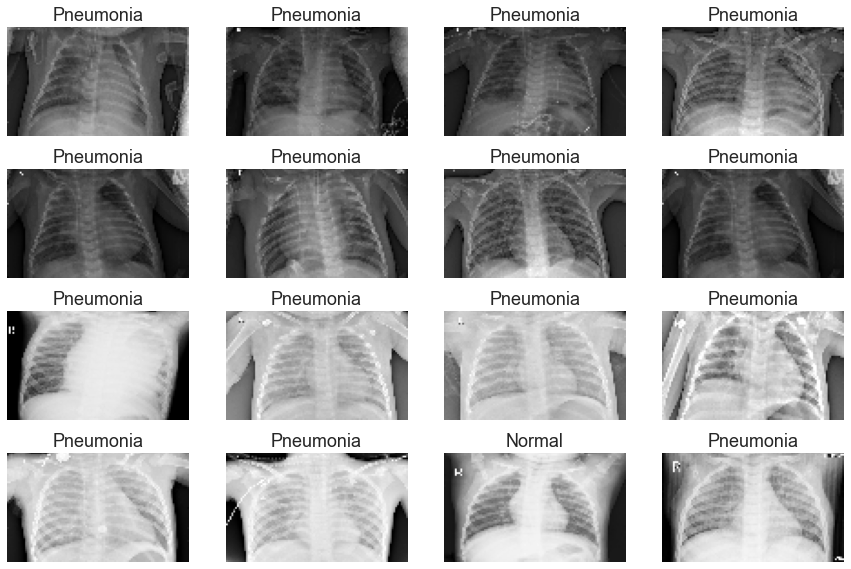

In [33]:
plot_pca_images(0, normal_grayscale, pneumonia_grayscale)

It can be clearly seen that the first PC is that of the total brightness of the images (the mean value of the pixels of the images). It can be noticed that both the first two rows (lowest score) and the last two rows (highest score) are both entirely made of pneumonia images, as such, this PC does not help our classification. However, this is a major PC that be accounted for by normalizing all the images according to their average pixel value. This could potentially help the model classify images.

#### Second PC

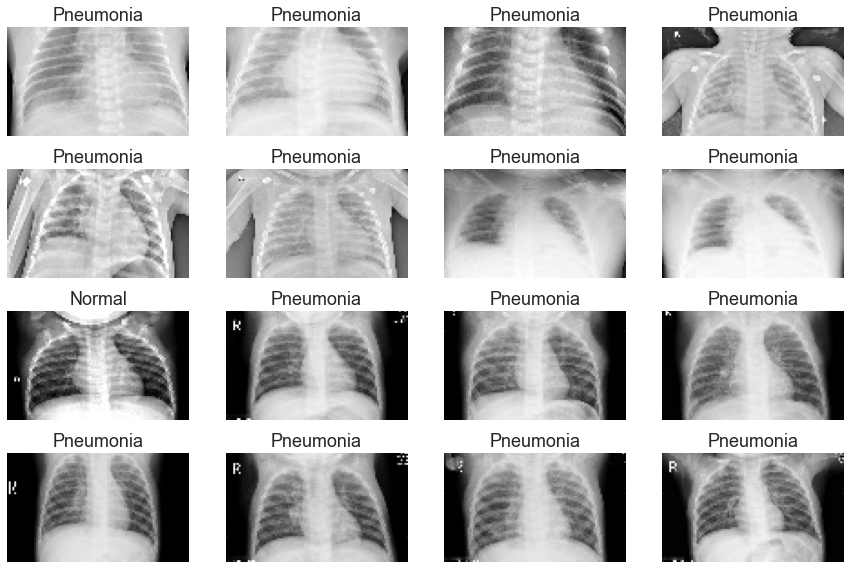

In [34]:
plot_pca_images(1, normal_grayscale, pneumonia_grayscale)

It can be seen that this PC corresponds to the amount of background that exists in the image. Similar to the first PC, this PC doesn't help us very much for classifying as all rows are consisted of entirely pneumonia images. We can normalize with regards to this PC as well, however, in contrast to the first PC, this PC accounts for a much smaller part of the variance and as such the 'return on investment' for normalizing in respect to it will be low.

#### Third PC

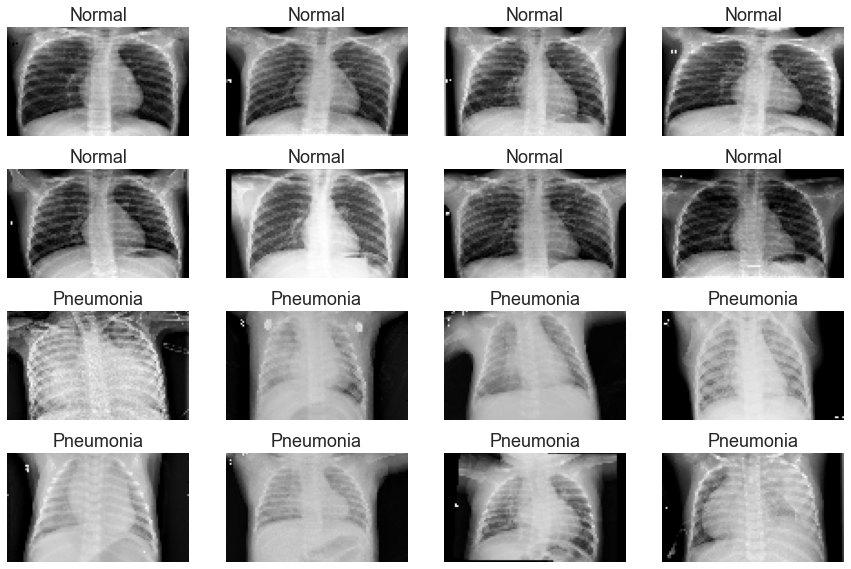

In [35]:
plot_pca_images(2, normal_grayscale, pneumonia_grayscale)

Jackpot! This PC has managed to completly divide between the pneumonia images and the normal images with an accuracy of 100% for 16 images.  In quick observation, it seems as this PC is the relative opacity of the ribcage. It can be seen that in the pneumonia images the ribcages are 'cloudy' and are of similar pixel value to the boundaries, whilst at the normal images the ribcages have a darker color and the boundaries are sharper and clearer to see. We will now attempt to use this PCA as a classfication tool for lung images.

The way this will be done will be by arranging the data in an array from the highest PC score to the lowest PC score. We will then divide the array to two arrays according to the relative size of the data. Every normal image in the first array will be counted and divided by the length of the array. Thats the accuracy for the normal image prediction. The same will be done for pneumonia images and the second array. The total accuracy will be the weighted average of both accuracies.

##### Testing the pca  

In [36]:
NORMAL_LENGTH = len(normal_data)
PNEUMONIA_LENGTH = len(pneumonia_data)

labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)

predicted_as_normal = np.argpartition(combined_reduced[:, 2], -NORMAL_LENGTH)[-NORMAL_LENGTH:]
predicted_as_pneumonia = np.argpartition(combined_reduced[:, 2], PNEUMONIA_LENGTH)[:PNEUMONIA_LENGTH]

normal_count = 0
pneumonia_count = 0

for image in predicted_as_pneumonia:
    if labels[image] == "Pneumonia":
        pneumonia_count += 1

for image in predicted_as_normal:
    if labels[image] == "Normal":
        normal_count += 1

pneumonia_group_accuracy = int(100*pneumonia_count/PNEUMONIA_LENGTH)
normal_group_accuracy = int(100*normal_count/NORMAL_LENGTH)
total_accuracy = int((pneumonia_group_accuracy * PNEUMONIA_LENGTH + normal_group_accuracy * NORMAL_LENGTH) / (NORMAL_LENGTH + PNEUMONIA_LENGTH ))

print(f"The pneumonia group contains: {pneumonia_group_accuracy} % pneumonia images")
print(f"The normal group contains: {normal_group_accuracy} % normal images")
print(f"The total accuracy is: {total_accuracy} % \n")


The pneumonia group contains: 86 % pneumonia images
The normal group contains: 63 % normal images
The total accuracy is: 79 % 



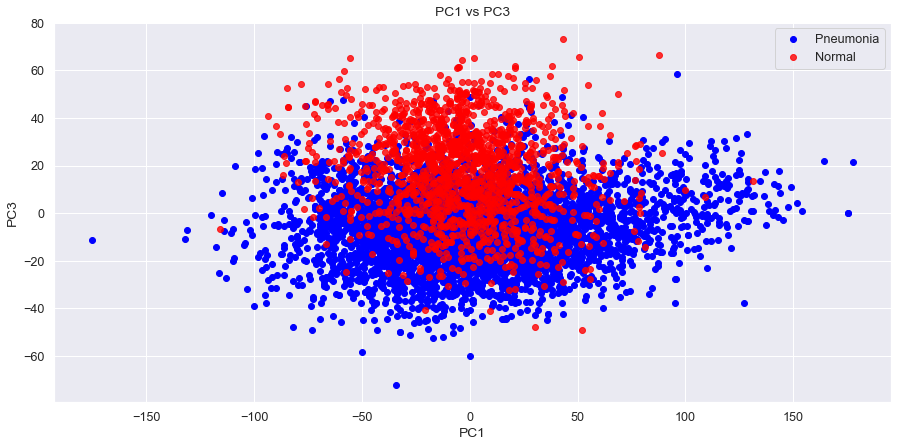

In [37]:
columns = ['PC' + str(i) for i in range(1,7)]
pca_df = pd.DataFrame(data=combined_reduced , columns=columns)

plt.scatter(pca_df.PC1[1575:], pca_df.PC3[1575:], c='blue')
plt.scatter(pca_df.PC1[:1575], pca_df.PC3[:1575], c='red', alpha=0.8)

plt.legend(['Pneumonia', 'Normal'])

plt.title('PC1 vs PC3')
plt.xlabel('PC1')
plt.ylabel('PC3')

plt.show()

The total accuracy of our third PC is quite impressive. We managed to find a classifying tool, without any complex models, that performs with accuracy of 79%. 
As seen in the scatter plot, PC1 doesn't split the data in any certain way, but PC3 groups Normal images and Pneumonia images, at least so we can see some separation between them.

#### Normalizing the first PC

In order to account for the first PCA and to reduce the interference of irelevant image properties, we will normalize all the images with respect to their mean pixel value and re-attempt the pca analysis. 

In [38]:
normal_normalized = []
pneumonia_normalized = []

normal_normalized_flattened = []
pneumonia_normalized_flattened = []

for index, image in enumerate(normal_grayscale):
    normal_normalized.append(image / np.mean(image))

for index, image in enumerate(pneumonia_grayscale):
    pneumonia_normalized.append(image / np.mean(image))

for index, image in enumerate(normal_flattened):
    normal_normalized_flattened.append(image / np.mean(image))

for index, image in enumerate(pneumonia_flattened):
    pneumonia_normalized_flattened.append(image / np.mean(image))

In order to watch the images, we discovered that the library Matplotlib, which we use for plotting images, normalized the images automaticly, without looking at the pixels value but by looking at the ratio between them.

In order to see the color normalization we perform, we will create plot function that disable the automatic normalization of Matplotlib, and plot the PCA images:

In [44]:
MAX_VALUE = np.amax(normal_normalized + pneumonia_normalized)
MIN_VALUE = np.amin(normal_normalized + pneumonia_normalized)

def plot_normalize_pca_images(pca_num, normal_data, pneumonia_data):
    highest_score_ids = np.argpartition(combined_reduced[:, pca_num], -8)[-8:]
    lowest_score_ids = np.argpartition(combined_reduced[:, pca_num], 8)[:8]

    combined_images = normal_data + pneumonia_data
    labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
    
    plt.figure(figsize=(15,10))
    for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
        img = combined_images[ids]
        plt.subplot(4,4,num+1)
        plt.axis("off")
        plt.imshow(img, cmap="gray", vmin=MIN_VALUE, vmax=MAX_VALUE)
        plt.title(f"{labels[ids]}",fontsize=18)

In [45]:
combined_pca = sklearn.preprocessing.StandardScaler().fit_transform(normal_normalized_flattened + pneumonia_normalized_flattened)
pca = sklearn.decomposition.PCA(n_components = 6)
pca.fit(combined_pca)
combined_reduced = pca.transform(combined_pca)
combined_pca_df = pd.DataFrame(data=combined_reduced,columns=['PC1','PC2','PC3','PC4','PC5','PC6'] )
combined_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-34.252956,-22.605889,17.331142,1.065024,-5.069910,45.246368
1,-14.090140,-27.830852,-15.620044,-3.522653,-3.236033,0.810461
2,-40.341136,-23.792984,18.041048,14.760920,6.122711,32.263262
3,-67.440044,-7.342272,14.820161,6.772993,30.478992,22.666360
4,-45.306657,-23.287056,15.237734,23.542267,9.610631,25.429706


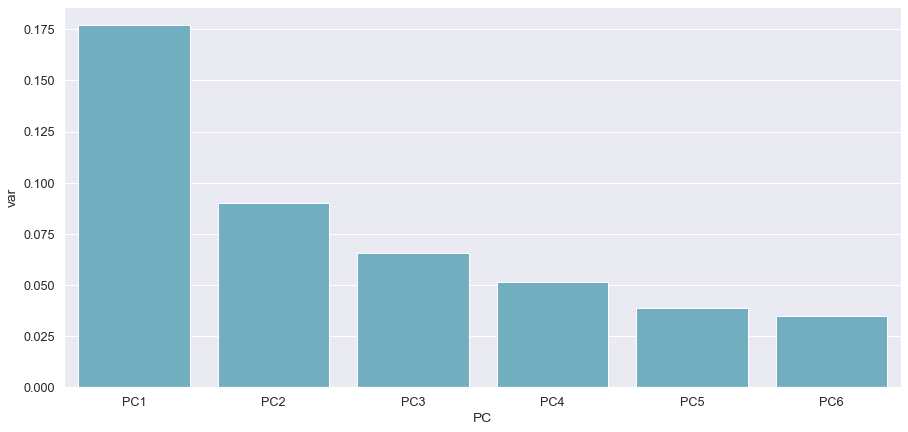

In [46]:
pca.explained_variance_ratio_

df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['PC1','PC2','PC3','PC4','PC5','PC6']})
sns.barplot(x='PC',y="var",data=df, color="c");

#### First PC

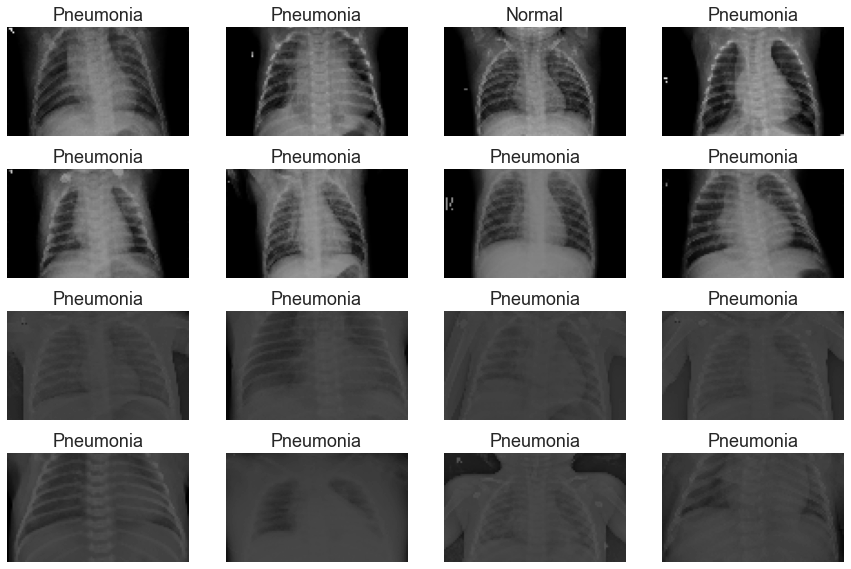

In [47]:
plot_normalize_pca_images(0, normal_normalized, pneumonia_normalized)

We can see that this represents the second PC of the original PCA analysis.

#### Second PC

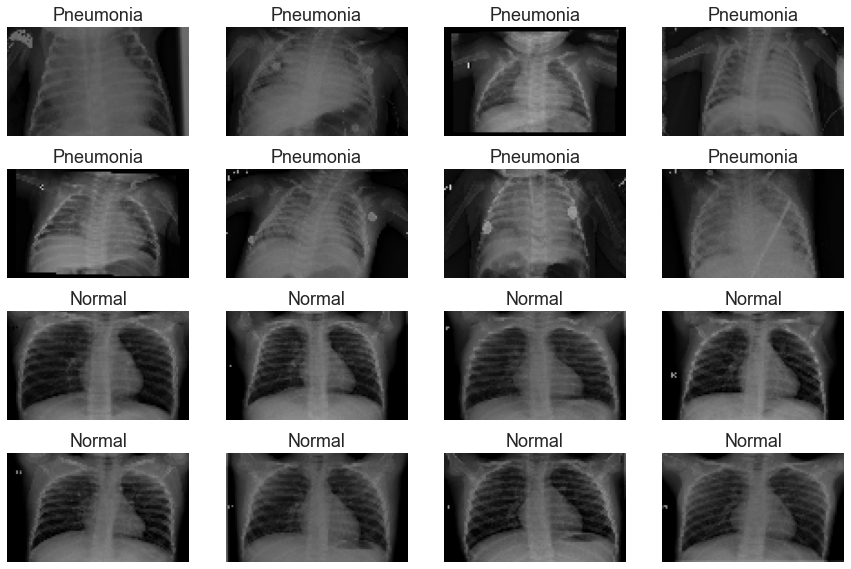

In [48]:
plot_normalize_pca_images(1, normal_normalized, pneumonia_normalized)

We can see that this represents the third PC from the original PCA analysis.

Lets re-check the third PC's accuracy and see if the accuracy has increased after normalizing with respect to the first PC.

##### Testing the pca  

In [49]:
NORMAL_LENGTH = len(normal_data)
PNEUMONIA_LENGTH = len(pneumonia_data)

predicted_as_normal = np.argpartition(combined_reduced[:, 1], NORMAL_LENGTH)[:NORMAL_LENGTH]
predicted_as_pneumonia = np.argpartition(combined_reduced[:, 1], -PNEUMONIA_LENGTH)[-PNEUMONIA_LENGTH:]

normal_count = 0
pneumonia_count = 0

for image in predicted_as_pneumonia:
    if labels[image] == "Pneumonia":
        pneumonia_count += 1

for image in predicted_as_normal:
    if labels[image] == "Normal":
        normal_count += 1

pneumonia_group_accuracy = int(100*pneumonia_count/PNEUMONIA_LENGTH)
normal_group_accuracy = int(100*normal_count/NORMAL_LENGTH)
total_accuracy = int((pneumonia_group_accuracy * PNEUMONIA_LENGTH + normal_group_accuracy * NORMAL_LENGTH) / (NORMAL_LENGTH + PNEUMONIA_LENGTH ))

print(f"The pneumonia group contains: {pneumonia_group_accuracy} % pneumonia images")
print(f"The normal group contains: {normal_group_accuracy} % normal images")
print(f"The total accuracy is: {total_accuracy} % \n")


The pneumonia group contains: 88 % pneumonia images
The normal group contains: 69 % normal images
The total accuracy is: 82 % 



Indeed as expected, by normalizing with respect to the first PC we have managed to increase further the accuracy of this classification tool. We have managed to reach an impressive 82% accuracy.

##### Visualizing the PCA

Through the analysis mentioned above, we have managed to reduce the problem almost entirely to one dimension. Let us visualize the PCA distrubition on a 2 dimensional graph to see the respective variance. 

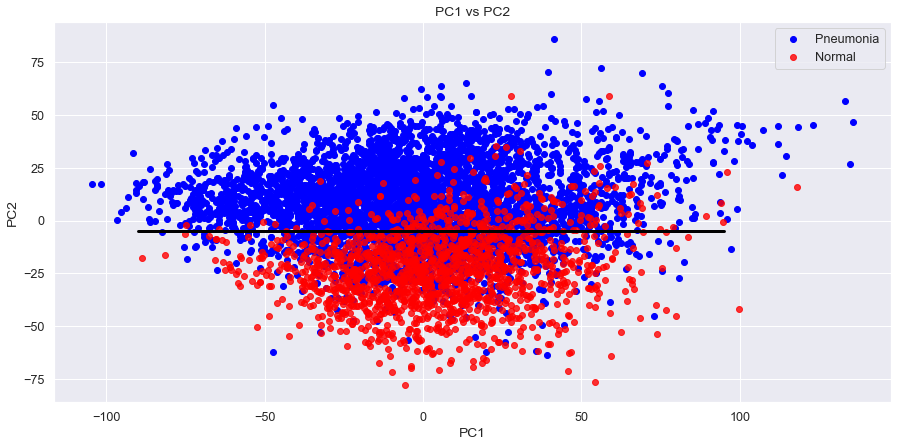

In [50]:
columns = ['PC' + str(i) for i in range(1,7)]
pca_df = pd.DataFrame(data=combined_reduced , columns=columns)


plt.scatter(pca_df.PC1[1575:], pca_df.PC2[1575:], c='blue')
plt.scatter(pca_df.PC1[:1575], pca_df.PC2[:1575], c='red', alpha=0.8)

plt.legend(['Pneumonia', 'Normal'])

plt.axhline(y=-5, xmin=0.1, xmax=0.8, color='black', linewidth=3)

plt.title('PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

As can be clearly seen, PC2 (PC3 before the dimension reduction) splits the data very well between the sick and healthy patients.

## Data Preperation For Classification

Before feeding the data to the model we need to perform various manipulations to conform to the format required by it. The following blocks of code will describe this process.

Firstly, we want to normalize all pixel values to be between 0 and 1. We will do this by finding the maximal value pixel of all pictures and dividing all pictures by this value.

In [51]:
normal_final = []
pneumonia_final = []

normal_final_flattened = []
pneumonia_final_flattened = []

for index, image in enumerate(normal_normalized):
    normal_final.append(image / MAX_VALUE)
    
for index, image in enumerate(pneumonia_normalized):
    pneumonia_final.append(image / MAX_VALUE)

for index, image in enumerate(normal_normalized_flattened):
    normal_final_flattened.append(image / MAX_VALUE)
    
for index, image in enumerate(pneumonia_normalized_flattened):
    pneumonia_final_flattened.append(image / MAX_VALUE)

Following that, we would like to split the data to train, validation and test groups. In order to use our data in multiple and variant models, we would split and adjust it in different ways with the use of NumPy and Sklearn libraries:

In [52]:
normal_labels = [0]*len(normal_final)
pneumonia_labels = [1]*len(pneumonia_final)

normal_train_with_val_data, normal_test_data, normal_train_with_val_labels, normal_test_labels = train_test_split(normal_final, normal_labels, test_size=0.33)
pneumonia_train_with_val_data, pneumonia_test_data, pneumonia_train_with_val_labels, pneumonia_test_labels = train_test_split(pneumonia_final, pneumonia_labels, test_size=0.33)

normal_train_data, normal_valid_data, normal_train_labels, normal_valid_labels = train_test_split(normal_train_with_val_data, normal_train_with_val_labels, test_size=0.2)
pneumonia_train_data, pneumonia_valid_data, pneumonia_train_labels, pneumonia_valid_labels = train_test_split(pneumonia_train_with_val_data, pneumonia_train_with_val_labels, test_size=0.2)

train_data = normal_train_data + pneumonia_train_data
train_labels = normal_train_labels + pneumonia_train_labels
NN_train_labels = to_categorical(train_labels, num_classes=2) 

valid_data = normal_valid_data + pneumonia_valid_data
valid_labels = normal_valid_labels + pneumonia_valid_labels
NN_valid_labels = to_categorical(valid_labels, num_classes=2) 

test_data = normal_test_data + pneumonia_test_data
test_labels = normal_test_labels + pneumonia_test_labels
NN_test_labels = to_categorical(test_labels, num_classes=2) 

train_data = np.array(train_data)
train_labels = np.array(train_labels)
NN_train_labels = np.array(NN_train_labels)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
NN_valid_labels = np.array(NN_valid_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
NN_test_labels = np.array(NN_test_labels)



The reason for the two types of labels is that the first one will be fed to the naive bayes and the second one will be fed to the neural network as it requires the labels to be categorical.

We now create the flattened data by simply reshaping the above variables to flat using numpy.reshape:


In [53]:
flatten_train_data = np.array([])
flatten_valid_data = np.array([])
flatten_test_data = np.array([])

flatten_train_data = train_data.reshape(train_data.shape[0],-1)
flatten_valid_data = valid_data.reshape(valid_data.shape[0],-1)
flatten_test_data = test_data.reshape(test_data.shape[0],-1)

train_data = train_data.reshape(train_data.shape[0], 60, 100, 1)
valid_data = valid_data.reshape(valid_data.shape[0], 60, 100, 1)
test_data = test_data.reshape(test_data.shape[0], 60, 100, 1)

Now our data is ready to use. Lets begin training the algorithm.

## Naive Bayes Classification Model
As seen in the PCA section, we can find simpler methods to predict and classify our data. In this section we will use a statistical method called naive bayes to attempt to analyze and extract useful information from the dataset.

Naive bayes takes a single 1-dimension vector as input and makes a prediction based on the values in the vector. In our case, we will feed the naive bayes algorithm a vector which will be the flattened image and the prediction will be either 'normal' or 'pneumonia'.

In [54]:
def plot_NB_confusion_matrix(test_model, testing_data, testing_labels, title):
    # Get predictions
    prediction = test_model.predict(testing_data)

    # Original labels
    orig_test_labels = testing_labels

    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, prediction)
    
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    plt.rcParams["figure.figsize"] = (7,6)

    sns.heatmap(cm,cmap= "Reds", linecolor = 'black' ,
                linewidth = 1 , annot = True, fmt='',
                xticklabels = ['Normal', 'Pneumonia'],
                yticklabels = ['Normal', 'Pneumonia']).set(xlabel='PREDICTED', ylabel='ACTUAL', title=title)
    plt.ylim([2,0])
    plt.show()
    
    # Calculate the final accuracy of each condition
    tn, fp, fn, tp = cm.values.ravel()
    print(f"Normal accuracy test score: {int(100*(tn/(tn+fp)))}%" )        
    print(f"Pneumonia accuracy test score: {int(100*(tp/(tp+fn)))}%" )
    print(f"Total accuracy test score: {int(100*((tn+tp)/(tn+fp+tp+fn)))}%")

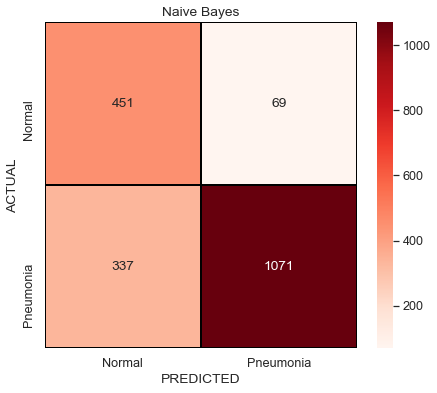

Normal accuracy test score: 86%
Pneumonia accuracy test score: 76%
Total accuracy test score: 78%


In [55]:
NB_flatten_train_data = np.asarray(flatten_train_data.tolist() + flatten_valid_data.tolist())
NB_train_labels =  np.asarray(train_labels.tolist() + valid_labels.tolist())

classifier = MultinomialNB()
classifier.fit(NB_flatten_train_data, NB_train_labels)

plot_NB_confusion_matrix(classifier, flatten_test_data, test_labels, "Naive Bayes")

The results indiciate a total accuracy of 78%. This isn't a bad result, but after seeing the PCA analysis perform better we believe that this model can be improved upon and as such we will try to do so. 

This will be done by instead of feeding the model the original image, we will instead use neural network methods to attempt to extract important features from the image and use them for the classification instead.

### Naive Bayes with Feature Extraction

In this part we will use Neural Networks as feature extraction models rather than classification tools. Our hope is that these models will find meaningful features in the images and then by feeding those to the naive bayes classification rather than the original image, we will be able to increase its accuracy.

There is no one particular way to do it, but the most common ways consist of building Neural Networks for image recognition, training them, and then extracting data from an intermediate layer of the model. The common belief is that this data will represent the original data as best as possible. 

### Autoencoder as Feature Extractor
Autoencoder is a type of neural network that can be used to learn a compressed representation of raw data.
An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.
The encoder can then be used as a data preparation technique to perform feature extraction on raw data that can be used to train a different machine learning model.

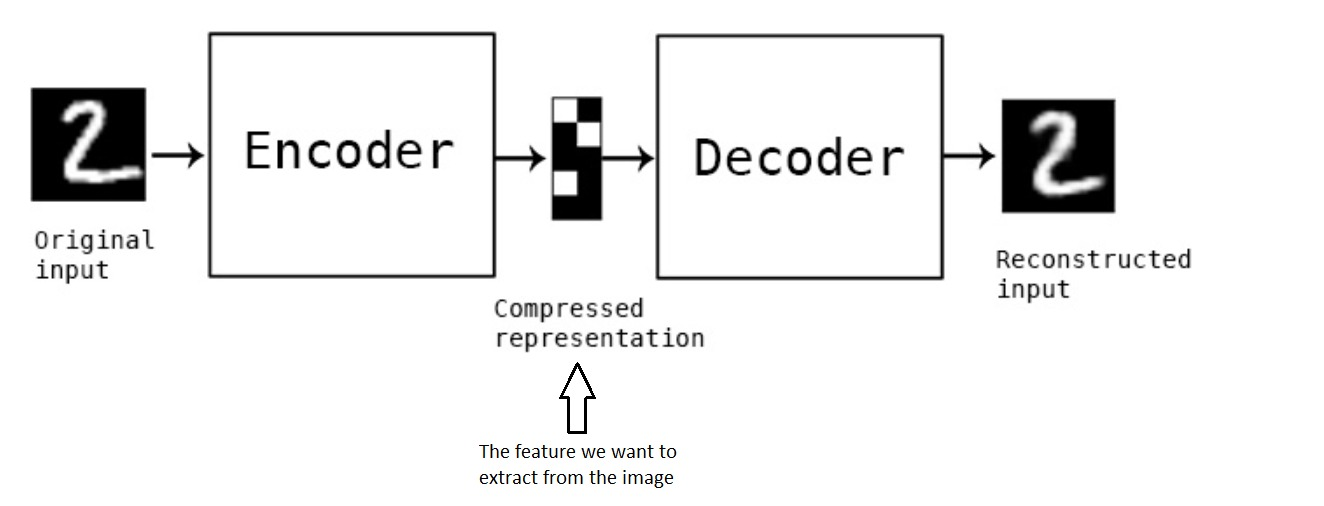

We will train an Autoencoder model to compress an image and reconstructe it back normal, as accurate as possible. Then we will take a vector from an intermediate layer that will represent the data.

In [242]:
input_img = layers.Input(shape=(60, 100, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

flatten_encoded = layers.Flatten(name='compressed')(encoded)
encoded = layers.Reshape((15, 25, 32))(flatten_encoded)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60, 100, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 100, 32)       320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 25, 32)        0         
_________________________________________________________________
compressed (Flatten)         (None, 12000)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 15, 25, 32)        0         
__________

In [244]:
%%time
autoencoder.fit(train_data, train_data,
                epochs=100,
                batch_size=128,
                shuffle=True,
                verbose=0,
                validation_data=(valid_data, valid_data))

Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

Lets compare the images before and after the reconstructions to see wether or not they are similar as we would want.

In [ ]:
fig, axis = plt.subplots(2,4)
plt.rcParams["figure.figsize"] = (15,7)

for index, image in enumerate(test_data[:4]):
    axis[0,index].imshow(image, cmap="gray")
    axis[0,index].set_title('Original image')

for index, image in enumerate(autoencoder.predict(test_data[:4])[:4]):
    axis[1,index].imshow(image, cmap="gray")
    axis[1,index].set_title('Reconstructed image')

plt.show()

Visually the results look indeed similar. Lets use a tool called 'cosine similarity' which is a common tool for comparing similarities between vectors (which in our case, represnt the images) to quantatively approximate the similary between the images. 

In [245]:
def calc_cosine_similarity(img_A,img_B):
    result = cosine_similarity(img_A.flatten().reshape(1,-1),img_B.flatten().reshape(1,-1))
    result = 100*result[0][0]
    return result

In [246]:
cos_sim = []
predictions = autoencoder.predict(test_data)

for i in range(len(predictions)):
    cos_sim.append(calc_cosine_similarity(predictions[i],test_data[i]))

result = np.mean(cos_sim)
print(("The average similarity between images is: {:.2f}%").format(result))

The average similarity between images is: 76.07%


Needless to say, this results pleases us. We conclude that indeed the autoencoder has managed to recreate an accurate image. Let us now use the features extracted from the intermediate layer to re-attempt the classification.

In [ ]:
layer_name = 'compressed'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                       outputs=autoencoder.get_layer(layer_name).output)

NB_train_data = np.asarray(train_data.tolist() + valid_data.tolist())

encoder_train = intermediate_layer_model(NB_train_data)
encoder_test = intermediate_layer_model(test_data)

classifier = MultinomialNB()
classifier.fit(encoder_train, NB_train_labels)

In [ ]:
plot_simple_confusion_matrix(classifier, encoder_test, test_labels, "Encoded vector with Naive Bayes")

We can see that this has not improved the results of the model. There can be a number of reasons for that. Rather than delving into this matter we will attempt a different way to classify the data.

### Img2vec

This is a module that vectorizes images using neural networks. Resnet50 was the first model that is supported, other models were released later. resnet50 is a residual convolutional neural network with 25.5 million parameters trained on more than a million images from the ImageNet database. As the name suggests, it has a total of 50 layers: 48 convolution layers, 1 MaxPool layer and 1 Average Pool layer.

We used git repository for the module Img2vec. What this function does is exactly what it sounds like - Image to  vector embedding. This library uses the ResNet50 model in TensorFlow Keras, pre-trained on Imagenet, to generate image embeddings.<br>This method takes an image as input, and through feature extraction process it creates 1-dimensional vector of 2048 numeric values that represents the main features of the original image.<br>This version of Img2vec is a clone of https://github.com/christiansafka/img2vec for TensorFlow Keras users.   <br>Due to problems we faced while downloading the package, we decided to copy the code directly from https://github.com/jaredwinick/img2vec-keras.

In [ ]:
# !pip install git://github.com/jaredwinick/img2vec-keras.git 

from tensorflow import keras
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np


_IMAGE_NET_TARGET_SIZE = (224, 224)


class Img2Vec(object):

    def __init__(self):
        
        model = resnet50.ResNet50(weights='imagenet')
        layer_name = 'avg_pool'
        self.intermediate_layer_model = Model(inputs=model.input, 
                                              outputs=model.get_layer(layer_name).output)

    def get_vec(self, image_path):
        """ Gets a vector embedding from an image.
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """
        img = image.load_img(image_path, target_size=_IMAGE_NET_TARGET_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        
        return intermediate_output[0]
    
if __name__ == "main":
     pass  

##### Create Img2vec data
This part looks similar to what we did before, but in order to use images with the function IMG2VEC, the input must be of it's original file format: JPG.<br>
The next block of code will create the same sizes of datasets, but with JPG files instead of images(matrix of pixels)

In [ ]:
# Creating lists of labels
vector_normal_labels = [0]*len(normal_data)
vector_pneumonia_labels = [1]*len(pneumonia_data)

#NORMAL_FILES = glob(NORMAL_PATH + "/*.jpeg")
#PNEUMONIA_FILES = glob(PNEUMONIA_PATH + "/*.jpeg")

# split the normal and pneumonia data to (TRAIN and VALIDATION : TEST)(66:33)
normal_train_with_val_data, normal_test_data, normal_train_with_val_labels, normal_test_labels = train_test_split(NORMAL_FILES, vector_normal_labels, test_size=0.33)
pneumonia_train_with_val_data, pneumonia_test_data, pneumonia_train_with_val_labels, pneumonia_test_labels = train_test_split(PNEUMONIA_FILES, vector_pneumonia_labels, test_size=0.33)

# split the normal and pneumonia TRAIN and VALIDATION to (TRAIN : VALIDATION)(80:20)
normal_train_data, normal_valid_data, normal_train_labels, normal_valid_labels = train_test_split(normal_train_with_val_data, normal_train_with_val_labels, test_size=0.2)
pneumonia_train_data, pneumonia_valid_data, pneumonia_train_labels, pneumonia_valid_labels = train_test_split(pneumonia_train_with_val_data, pneumonia_train_with_val_labels, test_size=0.2)

# concatenate normal and pneumonia data
raw_train_data = normal_train_data + pneumonia_train_data
raw_valid_data = normal_valid_data + pneumonia_valid_data
raw_test_data = normal_test_data + pneumonia_test_data

# compress all data to numpy arrays
raw_train_data = np.array(raw_train_data)
raw_valid_data = np.array(raw_valid_data)
raw_test_data = np.array(raw_test_data)

In [ ]:
# verification of TRAIN, VALIDATION, TEST img2vec data
print(raw_train_data.shape)
print(raw_valid_data.shape)
print(raw_test_data.shape)

#### Create vectors of our images

In [ ]:
%%time
img2vec_train_data = []
img2vec_valid_data = []
img2vec_test_data = []

# intiate vectors
for img in tqdm(raw_train_data):
    img2vec_train_data.append(img2vec.get_vec(img))
    
for img in tqdm(raw_valid_data):
    img2vec_valid_data.append(img2vec.get_vec(img))
    
for img in tqdm(raw_test_data):
    img2vec_test_data.append(img2vec.get_vec(img)) 
    
# compress all data to numpy arrays
img2vec_train_data = np.array(img2vec_train_data)
img2vec_valid_data = np.array(img2vecr_valid_data)
img2vec_test_data = np.array(img2vec_test_data)

In [ ]:
print(img2vec_train_data.shape)
print(img2vec_valid_data.shape)
print(img2vec_test_data.shape)

In [ ]:
# This last 2 blocks took about 6 hours, so the first thing to do was to save the results for future use.
# This is how to save and load them(when you have the files stored on the computer in the SAME DIRECTORY:

# SAVE IMG2VEC DATA
# np.save('img2vec_train_data.npy', img2vec_train_data)
# np.save('img2vec_valid_data.npy', img2vec_valid_data)
# np.save('img2vec_test_data.npy', img2vec_test_data)
#
# LOAD IMG2VEC DATA
img2vec_train_data = np.load('img2vec_train_data.npy')
img2vec_valid_data = np.load('img2vec_valid_data.npy')
img2vec_test_data = np.load('img2vec_test_data.npy')

###  Naive Bayes with Img2vec 

In [ ]:
NB_img2vec_train_data = np.asarray(img2vec_train_data.tolist() + img2vec_valid_data.tolist())

classifier = MultinomialNB()
classifier.fit(NB_img2vec_train_data, NB_train_labels)

plot_simple_confusion_matrix(classifier, img2vec_test_data, test_labels, "Img2vec with Naive Bayes")

Wow! our img2vec method perform great and by using the embedded vectors in Naive Bayes we recieved classification accuaracy of 89%!

### Conclusion Thus Far
We tested 3 types of data with Naive Bayes classifier to predict images as normal or pneumonia. 
- Original images as 1-dimensional vector.
- Features Extraction data from a train Autoencoder.
- Deep learning image embeddings using pre-trained ResNet50 - Img2vec.

In [ ]:
## TODO Table to show the results thus far.

## Basic neural network

After finishing testing our data with Naive Bayes models it is finally time to create a Neural Network model and train it on the data. The first step will be to build a relatively simple neural network, that will recieve a 1-dimensional vector representing each image.

In [ ]:
def basic_neural_network(input_shape):
    model = Sequential()

    model.add(Dense(512, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))

    model.summary()
    return model

In [ ]:
model = basic_neural_network((100*60,))

Now that we have a Neural Network model, let's train it, but first we will add plotting functions, early stop parameters and learning decay, in order to improve out model's learning process and to save resources when the learning process is not improving any more:

In [ ]:
def plot_results(test_model, testing_data, testing_labels):
    score = test_model.evaluate(testing_data, testing_labels, verbose=1)
    print("\nThe final results are:\n")
    print(f'Test loss: {int(100*score[0])}%')
    print(f'Test accuracy: {int(100*score[1])}%')

    
    
def plot_history(model_fit):
    plt.rcParams["figure.figsize"] = (15,8)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_fit.history[metric])
        ax[i].plot(model_fit.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

        
        
def plot_NN_confusion_matrix(test_model, testing_data, testing_labels, title):
    # Get predictions
    prediction = test_model.predict(testing_data, batch_size=16)
    prediction = np.argmax(prediction, axis=-1)
    
    # Original labels
    orig_test_labels = np.argmax(testing_labels, axis=-1)
    
    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, prediction)
    
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    plt.rcParams["figure.figsize"] = (7,6)
    sns.heatmap(cm,cmap= "Reds", linecolor = 'black' ,
                linewidth = 1 , annot = True, fmt='',
                xticklabels = ['Normal', 'Pneumonia'],
                yticklabels = ['Normal', 'Pneumonia']).set(xlabel='Predicted', ylabel='Actual', title=title)
    plt.show()
    
    tn, fp, fn, tp = cm.values.ravel()
    print(f"Normal accuracy test score: {int(100*(tn/(tn+fp)))}%" )        
    print(f"Pneumonia accuracy test score: {int(100*(tp/(tp+fn)))}%" )
    print(f"Total accuracy test score: {int(100*((tn+tp)/(tn+fp+tp+fn)))}%")

In [ ]:
LR_reduce = ReduceLROnPlateau(monitor='val_accuracy',
                           factor=.5,
                           patience=10,
                           min_lr=.000001,
                           verbose=1)

ES_monitor = EarlyStopping(monitor='val_loss', patience=20)

### Imbalance dataset solution
Due to the imbalance dataset we have, a solution we propose is to create class weights for the models we are about to train and by that make the learning process accurate as much as possible without any biases that might occur with imbalance dataset.

In [ ]:
weights = class_weight.compute_class_weight('balanced',
                                                 [0, 1],
                                                 train_labels)
weights_dict = dict(enumerate(weights))

The model now will get compiled and fit to the data:

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

basic_NN = model.fit(flatten_train_data, NN_train_labels,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(flatten_valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

In [ ]:
plot_results(model, flatten_test_data, NN_test_labels)

This results are great. It looks like our simplest model classifies normal and pneumonia images with an accuracy of 93%. But in order to understand the results better, let's plot them first in as graph and confusion matrix:

In [ ]:
plot_history(basic_NN)

This brings some concerns about the model overfitting  the data. Let's check a differenet approach to examine it

In [ ]:
plot_NN_confusion_matrix(model, flatten_test_data, NN_test_labels, "Basic Neural Network")

So the model actually perform with accuaracy of 93% and by the confusion matrix we can see his efficiency, eventhough in the graph we suspect the model is overfitting, it is shown that the model really gets the right answers on the test data.(the graph check the train vs validation data where the confusion matrix checks unrelated data that the model didn't met before, which is the test data)

### Basic neural network with img2vec
After seeing the results of the img2vec model with the Naive Bayes we will now test it againg, but with an actual Neural Network.

In [ ]:
model = basic_neural_network((2048,))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

basic_NN_with_img2vec = model.fit(img2vec_train_data, NN_train_labels,
                        batch_size=128,
                        epochs=100,
                        verbose=1,
                        shuffle=True,
                        validation_data=(img2vec_valid_data, NN_valid_labels),
                        class_weight=weights_dict,
                        callbacks = [LR_reduce, ES_monitor])

In [ ]:
plot_results(model, img2vec_test_data, NN_test_labels)

In [ ]:
plot_history(basic_NN_with_img2vec)

In [ ]:
plot_NN_confusion_matrix(model, img2vec_test_data, NN_test_labels, "Basic Neural Network with img2vec")

AWESOME!!!!!

### Convolutional Neural Network
Let's test our images in their original format which is a 2D images. 

### first attempt

In [ ]:
CNN_model = Sequential()

CNN_model.add(Conv2D(32, kernel_size = 4, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(128, kernel_size = 2, activation="relu", padding='same'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Flatten())

CNN_model.add(Dense(256, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(128, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(64, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(2, activation='softmax'))

CNN_model.summary()

Now we can compile the model with 'adam' optimizer and a binary cross entropy loss function that fits  the kind of classification we are dealing with.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = CNN_model.fit(train_data, NN_train_labels,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

### Results

In [ ]:
plot_results(CNN_model, test_data, NN_test_labels)

In [ ]:
plot_history(history)

Seems like our model is overfitting the data. Eventhough the accuracy of the model is great with 95% efficacy.<br>Let's plot a confusion matrix to check the results

In [ ]:
plot_NN_confusion_matrix(CNN_model, test_data, NN_test_labels, "First attempt - Convolutional Neural Network(CNN)")

### Second attempt
Let's try to double the conv layers, especially at the early process of the model, hopefully it will add some value to the learning abbilities of the model.

In [ ]:
CNN_condense_model = Sequential()

CNN_condense_model.add(Conv2D(32, kernel_size = 2, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_condense_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_condense_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_condense_model.add(Conv2D(128, kernel_size = 4, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(3, 3)))

CNN_condense_model.add(Conv2D(128, kernel_size = 4, activation="relu", padding='same'))
CNN_condense_model.add(Conv2D(256, kernel_size = 5, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(4, 4)))

CNN_condense_model.add(Flatten())

CNN_condense_model.add(Dense(256, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(128, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(64, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(2, activation='softmax'))

CNN_condense_model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = CNN_condense_model.fit(train_data, NN_train_labels,
                    batch_size = 128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

### Results


In [ ]:
plot_results(CNN_condense_model, test_data, NN_test_labels)

In [ ]:
plot_history(history)

In [ ]:
plot_NN_confusion_matrix(CNN_condense_model, test_data, NN_test_labels, "Second attempt - Convolutional Neural Network(CNN)")

The results are still great but didn't improve compare to the first attempt nor to the basic neural networks. It's time to pick a different approach.

## SHAP Values
SHAP — which stands for SHapley Additive exPlanations — is probably the state of the art in Machine Learning explainability. This algorithm was first published in 2017 by Lundberg and Lee (https://arxiv.org/abs/1705.07874) and it is a brilliant way to reverse-engineer the output of any predictive algorithm.
SHAP values are used whenever you have a complex model (could be a gradient boosting, a neural network, or anything that takes some features as input and produces some predictions as output) and you want to understand what decisions the model is making.
SHAP values are based on Shapley values, a concept coming from game theory. In a nutshell, the Shapley value is a solution concept in cooperative game theory which describe the impact of each player in the game on acheiving the common goal, and by that can define how much each player "contribute" in acheiving the goal.
When used in Machine Learning, the "game" stands for observation by a model, and the "players" are the features tested by the model. This gives us the option to look behind the scene of the decition making of the Neural Network model and look which feature impact the most on a given prediction.
A CNN model predict WHAT is every image, and the SHAP values tells us WHY.

In this part we will take the wrong prediction of the CNN models and try to understand where the models fall short. We used Softmax Activation function as our output layer. It is used to normalize the output of the network to a probability distribution over predicted output classes, which in our case we have only 2: Normal or Pneumonia. We will use the values of the last layer to find the wrong predictions of our model and examine thier SHAP values.
This code was taken from https://github.com/slundberg/shap.

#### Functions to test WRONG predictions

In [ ]:
NUM_OF_TOP_MISTAKES = 10

# calculate the wrong predictions, distribution of answers by the model, top wrong predictions images
def calc_SHAP_mistakes_values(model, testing_data, testing_labels):
    
    pred = model.predict(testing_data)

    Y_pred_classes = np.argmax(pred,axis = 1) 
    Y_true = np.argmax(testing_labels,axis = 1)

    errors = (Y_pred_classes - Y_true != 0)

    wrong_pred_labels = Y_pred_classes[errors]
    wrong_pred_distribution = pred[errors]
    true_labels = Y_true[errors]
    wrong_images = testing_data[errors]


    Y_pred_errors_prob = np.max(wrong_pred_distribution, axis = 1)
    true_prob_errors = np.diagonal(np.take(wrong_pred_distribution, true_labels, axis=1))
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    top_mistakes = sorted_dela_errors[-NUM_OF_TOP_MISTAKES:]
    
    return top_mistakes, wrong_images, wrong_pred_labels, true_labels, wrong_pred_distribution


# plot the wrong predictions
def plot_mistakes(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            
            if pred_errors[error] == 1:
                prediction = "Pneumonia"
            else:
                prediction = "Normal"
                
            if obs_errors[error] == 1:
                original = "Pneumonia"
            else:
                original = "Normal"
                
            ax[row,col].imshow((img_errors[error]).reshape((60,100)), cmap="gray")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(prediction,original))
            n += 1
    plt.rcParams["figure.figsize"] = (15,8)
    plt.show()
    
    
# plot the SHAP values of images with the answers probability    
def plot_SHAP_values(model, testing_data, wrong_pred, wrong_pred_index):

    explainer = shap.DeepExplainer(model, (testing_data[0:100])) # amount of images to create background 
    
    conditions = ["Normal", "Pneumonia"]

    for i in wrong_pred_index[:3]:     #Check out the 5 data that the model has mistakenly predicted.
    
    #Calculates the SHAP value.
        shap_values = explainer.shap_values(wrong_pred[[i]])
    
        if wrong_pred_labels[i] == 1:
            prediction = "Pneumonia"
        else:
            prediction = "Normal"
    
        if true_labels[i] == 1:
            original = "Pneumonia"
        else:
            original = "Normal"
        
        
        #calculate the answers probability
        index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(pred_dist[i][num]) for num, x in enumerate(conditions)]).reshape(1,2)
        print("Predicted label :{}\nTrue label :{}".format(prediction,original))
    
        #Displays the results.
        shap.image_plot(shap_values, wrong_pred[[i]] ,index_names ,show=False)
#        plt.figure(figsize=(15,8))
        plt.show()

### First attempt


#### Testing SHAP values of wrong predictions by our model

In [ ]:
# load the varaiables
top_mistakes, wrong_images, wrong_pred_labels, true_labels, pred_dist = calc_SHAP_mistakes_values(CNN_model, test_data, NN_test_labels)

Let's plot first the 10 top mistakes to see it in our own eyes

In [ ]:
plot_mistakes(top_mistakes, wrong_images, wrong_pred_labels, true_labels)

Now it's time to let the SHAP method do his magic:

In [ ]:
plot_SHAP_values(CNN_model, test_data, wrong_images, top_mistakes)

In [ ]:
# TODO
# Elaborate on what we see in the images with the SHAP values above

### Second attempt

In [ ]:
# load the varaiables
top_mistakes, wrong_images, wrong_pred_labels, true_labels, pred_dist = calc_SHAP_mistakes_values(CNN_condense_model, test_data, NN_test_labels)

plot_mistakes(top_mistakes, wrong_images, wrong_pred_labels, true_labels)

In [ ]:
plot_SHAP_values(CNN_condense_model, test_data, wrong_images, top_mistakes)

### Last attempt
#### Data Transformations and Augmentation


In [ ]:
# construct the training image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             shear_range=.15,
                              zoom_range=.15,
                              width_shift_range=.15,
                              height_shift_range=.15,
                              horizontal_flip=True,
                              fill_mode='nearest')

### CNN with Data Generation

In [ ]:
CNN_gen_model = Sequential()

CNN_gen_model.add(Conv2D(32, kernel_size = 4, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Conv2D(128, kernel_size = 2, activation="relu", padding='same'))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Flatten())

CNN_gen_model.add(Dense(256, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(128, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(64, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(2, activation='softmax'))

CNN_gen_model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = CNN_gen_model.fit(datagen.flow(train_data, NN_train_labels, batch_size=128 ),
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

In [ ]:
plot_results(CNN_gen_model, test_data, NN_test_labels)

In [ ]:
plot_history(history)

In [ ]:
plot_NN_confusion_matrix(CNN_gen_model, test_data, NN_test_labels, "CNN with Data Generation")

In [ ]:
# TODO: elaborate about the results

# Conclusions
#### Results


## Self reflection/Discussion
